In [1]:
import torch
from dataset import collate_fn, get_dataset, get_dataset_train, get_dataset_valid
from torch import nn
from torch.utils.data import DataLoader
from model import get_model, clip_loss
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score
import pandas as pd

/home/eduardo/Documents/TCC/TCC-graphs-CLIP-test2/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="../data/checkpoints/clip-model",
    num_train_epochs=50,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,
    warmup_steps=50,
    learning_rate=1e-5,
    weight_decay=0.01,
    logging_steps=10,
    save_strategy="epoch",
    optim="adamw_torch_fused",
    bf16=True if torch.cuda.is_available() else False,
    report_to="none",
    dataloader_num_workers=6,
)


In [3]:
def compute_sims(model, ds, device="cpu"):
    model.eval()
    all_image_embs = []
    all_texts = []

    with torch.no_grad():
        for imgs, texts in ds:
            imgs = imgs.to(device).unsqueeze(0)
            all_image_embs.append(model.project_images(imgs))
            all_texts.append(texts)  # mantém lista de strings

        # concatena embeddings de todas as imagens
        image_embs = torch.cat(all_image_embs, dim=0)  # (num_images, dim)

        # codifica todos os textos
        text_embs = model.project_texts(all_texts).to(device)  # (num_texts, dim)

        # matriz de similaridade coseno
        sims = torch.matmul(image_embs, text_embs.T)  # (num_images, num_texts)

    return sims

@torch.no_grad()
def compute_silhouette(model, ds, device):
    # Calcula o índice de silhueta com base nas similaridades entre
    # as 1000 primeiras e 1000 últimas imagens comparadas com todos os textos.

    # Similaridade entre imagens e textos
    sims = compute_sims(model, ds, device)  # (num_images, num_texts)

    # Converte similaridade → distância exponencial
    dist = torch.exp(-sims.detach().cpu())

    # Normaliza [0, 1] antes do cálculo da silhueta
    dist = (dist - dist.min()) / (dist.max() - dist.min())

    # Inicializa a diagonal principal com zeros
    idx = torch.arange(dist.size(0))
    dist[idx, idx] = 0

    # cria rótulos (metade positivas, metade negativas)
    # ex: primeiros 1000 pares são positivos, últimos 1000 negativos
    n = dist.shape[0]
    half = n // 2
    labels = np.zeros(n)
    labels[:half] = 1  # primeiros = positivos

    # Calcula índice de silhueta
    score = silhouette_score(dist, labels, metric="precomputed")

    return score

In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


# Configurações
device = "cuda" if torch.cuda.is_available() else "cpu"
model = get_model()
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
metrics = []

ds_train = get_dataset_train("../Graphs/star-grid-train/images", "../Graphs/star-grid-train/edgelists.json", split=0)
ds_valid = get_dataset_valid("../Graphs/star-grid-valid/images", "../Graphs/star-grid-valid/edgelists.json", split=0)

dl_train = torch.utils.data.DataLoader(ds_train,
                                 batch_size=training_args.per_device_train_batch_size,
                                 shuffle=True,
                                 num_workers=training_args.dataloader_num_workers, 
                                 collate_fn=collate_fn,)

dl_valid = torch.utils.data.DataLoader(ds_valid,
                                    batch_size=training_args.per_device_train_batch_size,
                                    shuffle=False,
                                    num_workers=training_args.dataloader_num_workers, 
                                    collate_fn=collate_fn,)

optimizer = torch.optim.AdamW(model.parameters(),
                              lr=training_args.learning_rate,
                              weight_decay=training_args.weight_decay)

model.to(device)

for epoch in range(int(training_args.num_train_epochs)):
    total_loss_train = 0
    model.train()
    for step, (imgs, texts) in enumerate(dl_train):
        imgs = imgs.to(device)

        # Tokeniza os textos do batch
        enc_texts = tokenizer(
            list(texts), padding=True, truncation=True, return_tensors="pt"
        ).to(device)

        optimizer.zero_grad()

        # logits = (batch_img, batch_text) → matriz (B, B)
        logits = model(imgs, list(texts))

        # CLIP loss (InfoNCE)
        loss = clip_loss(logits)
        loss.backward()

        # grad accumulation
        if (step + 1) % training_args.gradient_accumulation_steps == 0:
            optimizer.step()

        total_loss_train += loss.item()

    with torch.no_grad():
        total_loss_valid = 0
        model.eval()
        for step, (imgs, texts) in enumerate(dl_valid):
        
            imgs = imgs.to(device)

            # Tokeniza os textos do batch
            enc_texts = tokenizer(
                list(texts), padding=True, truncation=True, return_tensors="pt"
            ).to(device)

            # logits = (batch_img, batch_text) → matriz (B, B)
            logits = model(imgs, list(texts))

            # CLIP loss (InfoNCE)
            loss = clip_loss(logits)

            total_loss_valid += loss.item()

    # logging
    avg_loss_train = total_loss_train / len(dl_train)
    avg_loss_valid = total_loss_valid / len(dl_valid)
    sil_score_train = compute_silhouette(model, ds_train, device=device)
    sil_score_valid = compute_silhouette(model, ds_valid, device=device)

    metrics.append([epoch, avg_loss_train, avg_loss_valid, sil_score_train, sil_score_valid])

    epoch_str = f"Epoch {epoch+1}/{training_args.num_train_epochs}"
    print("\t\tLoss Treinamento\tLoss Validacao\tSilhueta Treinamento\tSilhueta Validacao")
    print(f"{epoch_str}\t{avg_loss_train:.4f}\t\t\t{avg_loss_valid:.4f}\t\t{sil_score_train:.4f}\t\t\t{sil_score_valid:.4f}")

df_metrics = pd.DataFrame(metrics, columns=['epoca', 'loss_train', 'loss_valid', 'sil_train', 'sil_valid'])
df_metrics.to_csv("Metricas Treinamento-Validacao-Star-Grid-Dataset-Dividido-50epoch.csv")

torch.save(model.state_dict(), "Modelo-Star-Grid-Dataset-Dividido-50epoch.ckpt")

Device set to use cpu


		Loss Treinamento	Loss Validacao	Silhueta Treinamento	Silhueta Validacao
Epoch 1/50	2.1067			2.0830		0.0162			0.0139
		Loss Treinamento	Loss Validacao	Silhueta Treinamento	Silhueta Validacao
Epoch 2/50	2.0867			2.0786		0.0334			0.0327
		Loss Treinamento	Loss Validacao	Silhueta Treinamento	Silhueta Validacao
Epoch 3/50	2.0765			2.0759		0.0516			0.0516
		Loss Treinamento	Loss Validacao	Silhueta Treinamento	Silhueta Validacao
Epoch 4/50	2.0643			2.0732		0.0862			0.0813
		Loss Treinamento	Loss Validacao	Silhueta Treinamento	Silhueta Validacao
Epoch 5/50	2.0524			2.0682		0.1184			0.1207
		Loss Treinamento	Loss Validacao	Silhueta Treinamento	Silhueta Validacao
Epoch 6/50	2.0317			2.0531		0.1390			0.1455
		Loss Treinamento	Loss Validacao	Silhueta Treinamento	Silhueta Validacao
Epoch 7/50	1.9678			2.0138		0.1089			0.1201
		Loss Treinamento	Loss Validacao	Silhueta Treinamento	Silhueta Validacao
Epoch 8/50	1.8709			1.9263		0.1101			0.1050
		Loss Treinamento	Loss Validacao	Silhueta Treinamento	S

In [ ]:
torch.save(model.state_dict(), "Modelo-Star-Grid-Dataset-Dividido-50epoch.ckpt")

In [6]:
len(ds_train)

2000

In [7]:
# Calcula similaridades
sims_train = compute_sims(model, ds_train, device=device)
sims_valid = compute_sims(model, ds_valid, device=device)

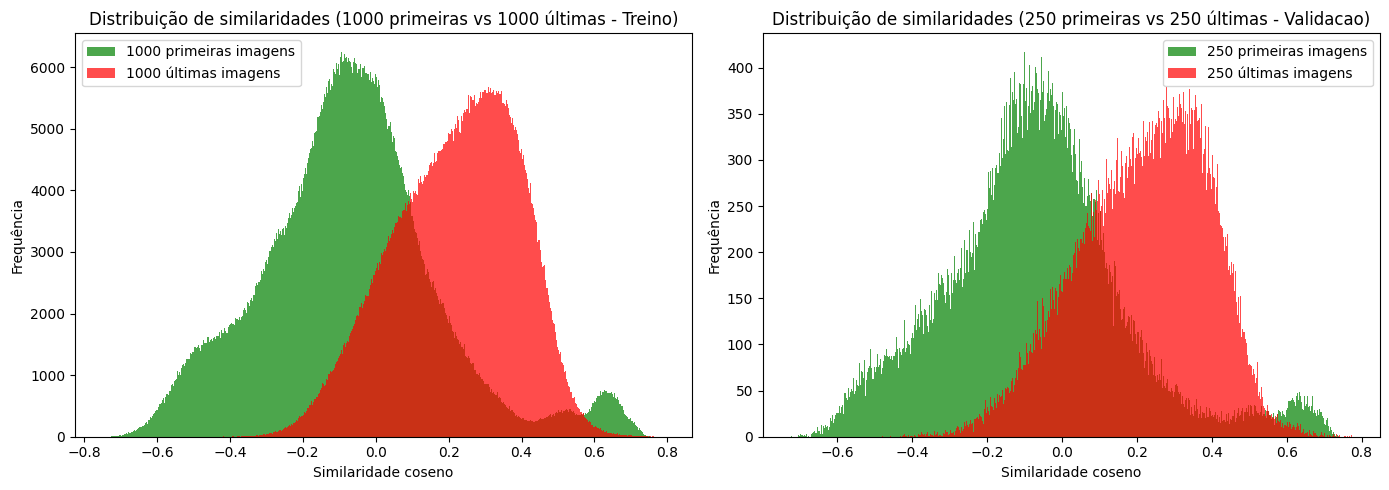

In [8]:
# Histograma comparando 1000 primeiras vs 1000 últimas imagens com todos os textos - treino
sims_first1000 = sims_train[:1000].reshape(-1)
sims_last1000 = sims_train[-1000:].reshape(-1)

# Histograma comparando 250 primeiras vs 250 últimas imagens com todos os textos - validacao
sims_first250 = sims_valid[:250].reshape(-1)
sims_last250 = sims_valid[-250:].reshape(-1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma 1000 vs 1000
axes[0].hist(sims_first1000.cpu().numpy(), bins=1000, alpha=0.7, color="green", label="1000 primeiras imagens")
axes[0].hist(sims_last1000.cpu().numpy(), bins=1000, alpha=0.7, color="red", label="1000 últimas imagens")
axes[0].set_title("Distribuição de similaridades (1000 primeiras vs 1000 últimas - Treino)")
axes[0].set_xlabel("Similaridade coseno")
axes[0].set_ylabel("Frequência")
axes[0].legend()

# Histograma 250 vs 250
axes[1].hist(sims_first250.cpu().numpy(), bins=1000, alpha=0.7, color="green", label="250 primeiras imagens")
axes[1].hist(sims_last250.cpu().numpy(), bins=1000, alpha=0.7, color="red", label="250 últimas imagens")
axes[1].set_title("Distribuição de similaridades (250 primeiras vs 250 últimas - Validacao)")
axes[1].set_xlabel("Similaridade coseno")
axes[1].set_ylabel("Frequência")
axes[1].legend()

plt.tight_layout()
plt.show()

In [9]:
sims_train.shape

torch.Size([2000, 2000])

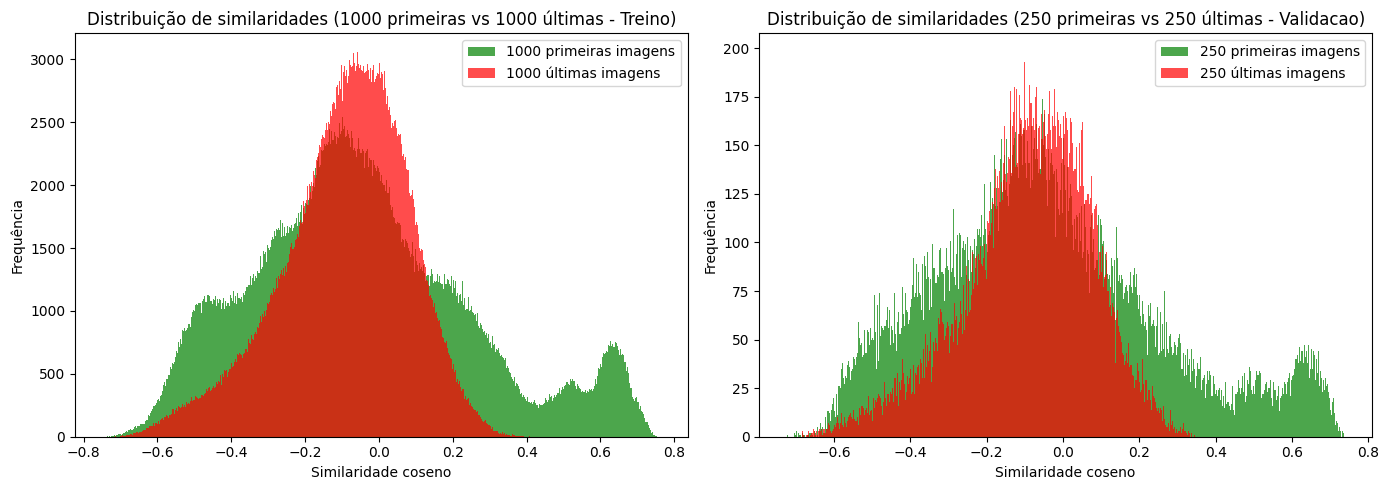

In [10]:
# Quadrante superior esquerdo x Quadrante superior direito
# [:x, :x] = Q1
# [:x, x:] = Q2
# [x:, :x] = Q3
# [x:, x:] = Q4
sims_first1000 = sims_train[:1000, :1000].reshape(-1)
sims_last1000 = sims_train[:1000, 1000:].reshape(-1)

sims_first250 = sims_valid[:250, :250].reshape(-1)
sims_last250 = sims_valid[:250, 250:].reshape(-1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma 1000 vs 1000
axes[0].hist(sims_first1000.cpu().numpy(), bins=1000, alpha=0.7, color="green", label="1000 primeiras imagens")
axes[0].hist(sims_last1000.cpu().numpy(), bins=1000, alpha=0.7, color="red", label="1000 últimas imagens")
axes[0].set_title("Distribuição de similaridades (1000 primeiras vs 1000 últimas - Treino)")
axes[0].set_xlabel("Similaridade coseno")
axes[0].set_ylabel("Frequência")
axes[0].legend()

# Histograma 250 vs 250
axes[1].hist(sims_first250.cpu().numpy(), bins=1000, alpha=0.7, color="green", label="250 primeiras imagens")
axes[1].hist(sims_last250.cpu().numpy(), bins=1000, alpha=0.7, color="red", label="250 últimas imagens")
axes[1].set_title("Distribuição de similaridades (250 primeiras vs 250 últimas - Validacao)")
axes[1].set_xlabel("Similaridade coseno")
axes[1].set_ylabel("Frequência")
axes[1].legend()

plt.tight_layout()
plt.show()

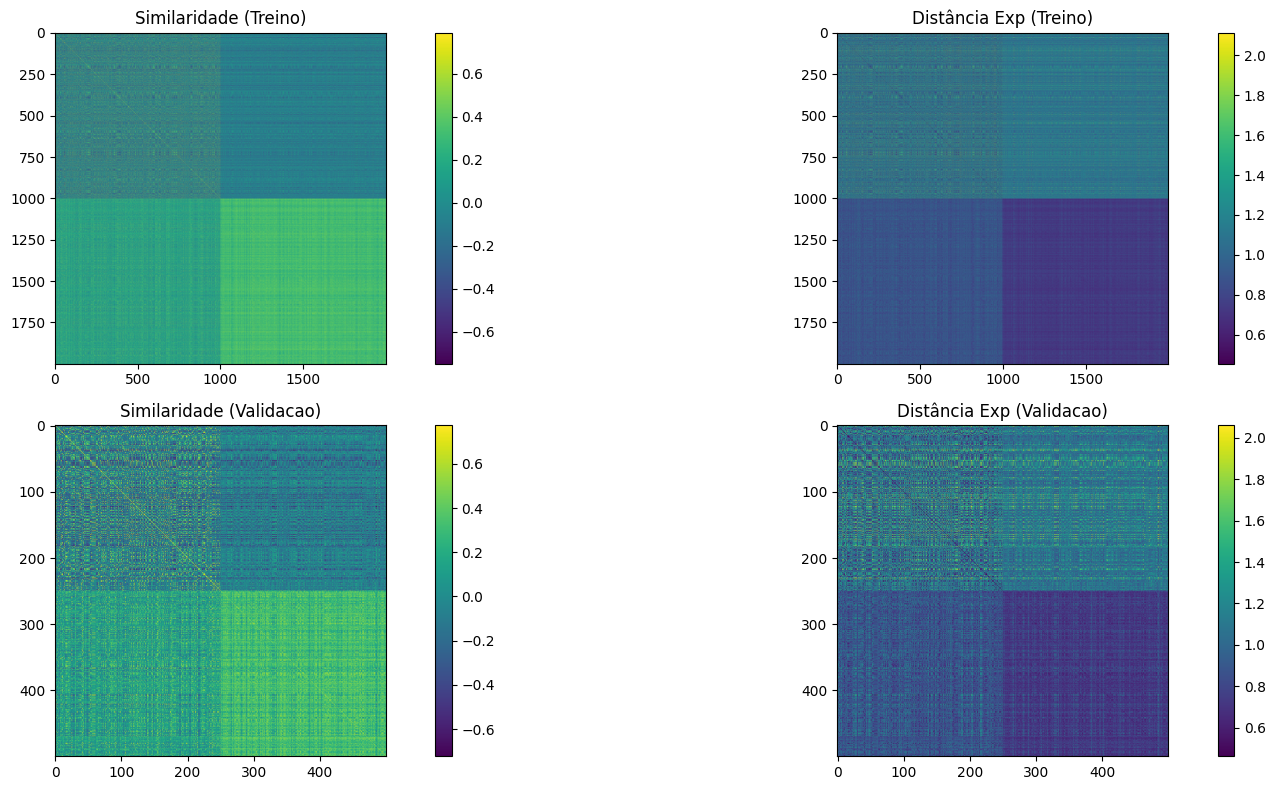

In [11]:
sims_train_matrix = sims_train.detach().cpu()
dist_train_matrix = torch.exp(-sims_train).detach().cpu()

sims_valid_matrix = sims_valid.detach().cpu()
dist_valid_matrix = torch.exp(-sims_valid).detach().cpu()

fig, axes = plt.subplots(2, 2, figsize=(18, 8))  # 2 linhas, 2 colunas
axes = axes.flatten()

# Plot da similaridade
im0 = axes[0].imshow(sims_train_matrix, cmap='viridis')
axes[0].set_title("Similaridade (Treino)")
fig.colorbar(im0, ax=axes[0])

# Plot da distância exponencial
im1 = axes[1].imshow(dist_train_matrix, cmap='viridis')
axes[1].set_title("Distância Exp (Treino)")
fig.colorbar(im1, ax=axes[1])

# Plot da similaridade
im2 = axes[2].imshow(sims_valid_matrix, cmap='viridis')
axes[2].set_title("Similaridade (Validacao)")
fig.colorbar(im2, ax=axes[2])

# Plot da distância exponencial
im3 = axes[3].imshow(dist_valid_matrix, cmap='viridis')
axes[3].set_title("Distância Exp (Validacao)")
fig.colorbar(im3, ax=axes[3])

plt.tight_layout()
plt.show()

In [48]:
from sklearn.metrics import top_k_accuracy_score

top = 5
top_k_train = top_k_accuracy_score(range(len(sims_train)), sims_train.cpu(), k=top)
top_k_valid = top_k_accuracy_score(range(len(sims_valid)), sims_valid.cpu(), k=top)

print(f"top{top} treino = {top_k_train}\ntop{top} validacao = {top_k_valid}")

top5 treino = 0.076
top5 validacao = 0.246


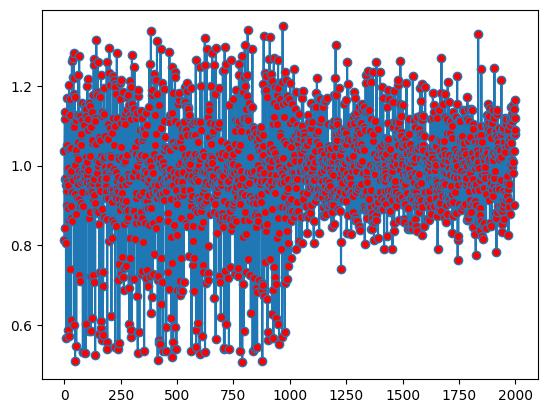

In [13]:
idx_ref = 600
sims_img = sims_train[idx_ref]
plt.plot(torch.exp(-sims_img.cpu()), "-o", markerfacecolor="red")


In [14]:
def organize(idx_ref, sims, ds, columns):

    sims_img = sims[idx_ref, columns]
    idx_ord = torch.argsort(sims_img)
    #sims_img_ord = sims_img[idx_ord]
    ds_ord = [ds[columns.start+idx][0] for idx in idx_ord]

    return ds_ord

ds_star_ord = organize(idx_ref, sims_train, ds_train, slice(0, 1000))
ds_grid_ord = organize(idx_ref, sims_train, ds_train, slice(1000, 2000))

#print(ds_star_ord[:10])
#print(ds_star_ord[-10:])
#print(ds_grid_ord[:10])
#print(ds_grid_ord[-10:])

In [15]:
[ds_train[idx][1] for idx in range(1990, 2000)]

['0-1 0-8 1-2 1-10 2-3 3-5 4-8 4-9 4-11 5-8 5-9 6-7 6-10 7-11',
 '0-1 0-6 0-7 1-2 1-10 2-8 2-11 3-6 3-7 4-7 5-10 6-9 8-9 10-11',
 '0-1 0-4 0-7 1-6 1-10 2-3 2-5 3-4 4-6 6-8 7-11 8-10 9-10 9-11',
 '0-4 0-5 0-8 1-5 1-8 2-6 3-7 3-10 4-9 6-10 8-9 8-10 9-11 10-11',
 '0-2 1-2 2-11 3-6 4-7 4-10 5-7 5-11 6-8 6-9 7-8 8-10 8-11 9-10',
 '0-1 0-5 0-7 1-2 2-9 3-4 3-6 4-8 4-11 6-10 6-11 7-10 7-11 8-9',
 '0-8 0-9 1-3 1-11 2-6 3-4 3-7 4-6 5-7 5-8 7-11 8-11 9-10 9-11',
 '0-2 0-3 0-9 1-4 2-8 2-10 2-11 3-11 4-6 4-8 5-8 6-7 7-10 9-10',
 '0-2 0-4 0-7 0-8 1-5 1-10 2-6 2-11 3-7 3-10 4-9 4-11 6-7 8-9',
 '0-3 0-8 1-2 1-10 1-11 2-3 4-6 4-9 4-11 5-9 5-11 6-8 7-9 8-10']

In [16]:
def sim_img_alltext(model, image, ds, device="cpu"):
    model.eval()
    all_texts = []

    with torch.no_grad():
        for _, texts in ds:
            all_texts.append(texts)  # mantém lista de strings

        img_emb = model.project_images(image.unsqueeze(0).to(device))

        # codifica todos os textos
        text_embs = model.project_texts(all_texts).to(device)  # (num_texts, dim)

        # matriz de similaridade coseno
        sims = torch.matmul(img_emb, text_embs.T)  # (num_images, num_texts)

    return sims

In [17]:
ds = get_dataset_train("../Graphs/star-grid-train/images", "../Graphs/star-grid-train/edgelists.json", split=0)
ds.ds.ids

['s0001',
 's0002',
 's0003',
 's0004',
 's0006',
 's0007',
 's0008',
 's0009',
 's0011',
 's0012',
 's0013',
 's0014',
 's0016',
 's0017',
 's0018',
 's0019',
 's0021',
 's0022',
 's0023',
 's0024',
 's0026',
 's0027',
 's0028',
 's0029',
 's0031',
 's0032',
 's0033',
 's0034',
 's0036',
 's0037',
 's0038',
 's0039',
 's0041',
 's0042',
 's0043',
 's0044',
 's0046',
 's0047',
 's0048',
 's0049',
 's0051',
 's0052',
 's0053',
 's0054',
 's0056',
 's0057',
 's0058',
 's0059',
 's0061',
 's0062',
 's0063',
 's0064',
 's0066',
 's0067',
 's0068',
 's0069',
 's0071',
 's0072',
 's0073',
 's0074',
 's0076',
 's0077',
 's0078',
 's0079',
 's0081',
 's0082',
 's0083',
 's0084',
 's0086',
 's0087',
 's0088',
 's0089',
 's0091',
 's0092',
 's0093',
 's0094',
 's0096',
 's0097',
 's0098',
 's0099',
 's0101',
 's0102',
 's0103',
 's0104',
 's0106',
 's0107',
 's0108',
 's0109',
 's0111',
 's0112',
 's0113',
 's0114',
 's0116',
 's0117',
 's0118',
 's0119',
 's0121',
 's0122',
 's0123',
 's0124',


In [18]:
len(ds)

2000

/tmp/ipykernel_9621/610776573.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


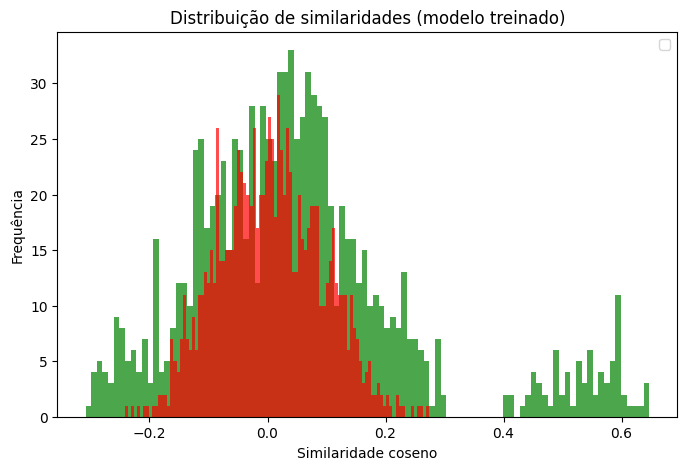

In [19]:
image, _ = ds[idx_ref]
sims2 = sim_img_alltext(model, image, ds, device=device)

sims_first1000 = sims2[0,:1000].reshape(-1)
sims_last1000 = sims2[0,1000:].reshape(-1)

plt.figure(figsize=(8,5))
plt.hist(sims_first1000.cpu().numpy(), bins=100, alpha=0.7, color="green")
plt.hist(sims_last1000.cpu().numpy(), bins=100, alpha=0.7, color="red")


plt.xlabel("Similaridade coseno")
plt.ylabel("Frequência")
plt.title("Distribuição de similaridades (modelo treinado)")
plt.legend()
plt.show()

In [20]:
sims2.shape

torch.Size([1, 2000])

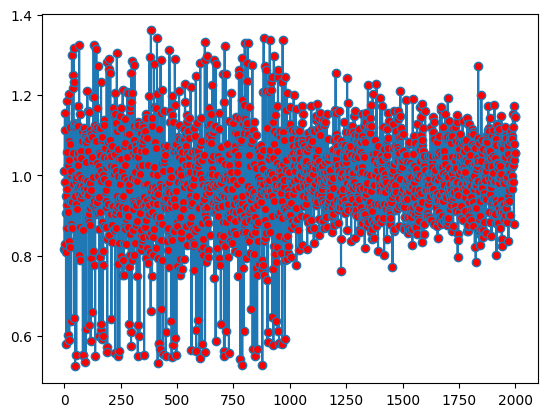

In [24]:
plt.plot(torch.exp(-sims2[0].cpu()), "-o", markerfacecolor="red")

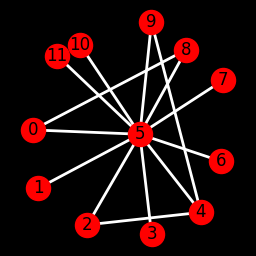

'0-5 0-8 1-5 2-4 2-5 3-5 4-5 4-9 5-6 5-7 5-8 5-9 5-10 5-11'

In [22]:
ds.transform = None
display(*ds[idx_ref])

'------estrelas menos similares--------'

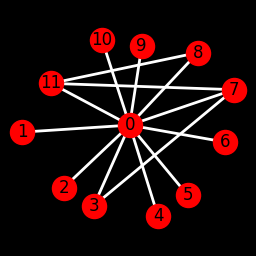

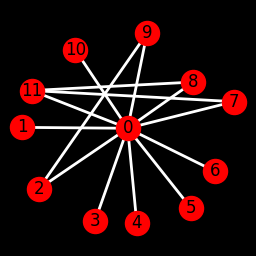

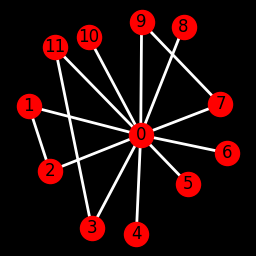

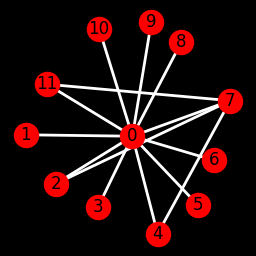

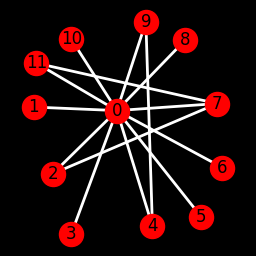

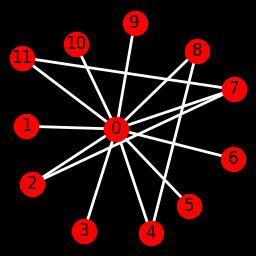

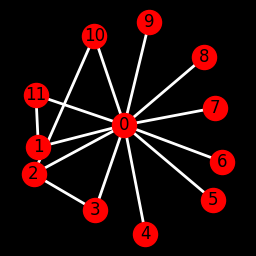

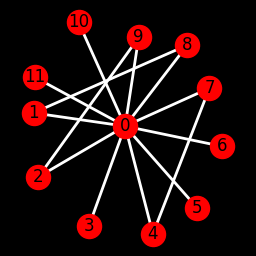

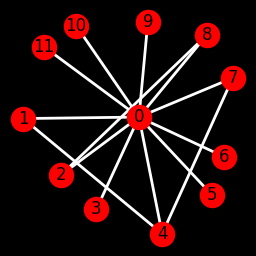

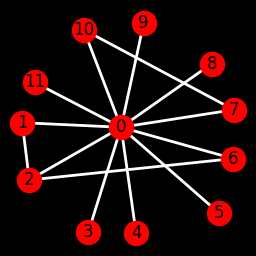

'------estrelas mais similares--------'

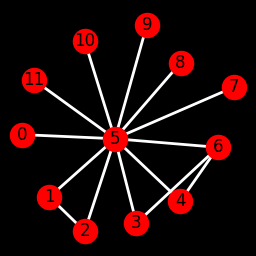

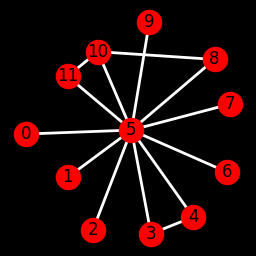

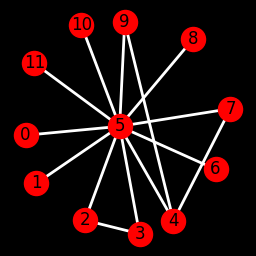

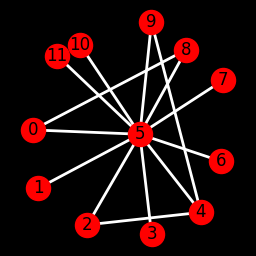

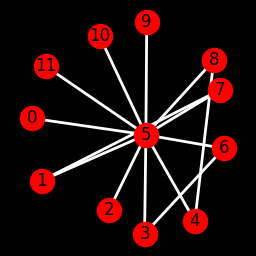

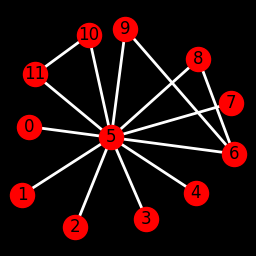

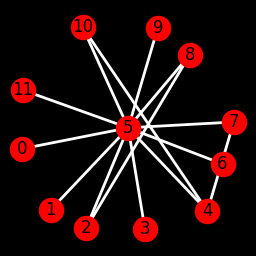

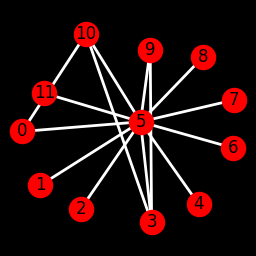

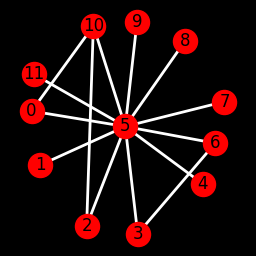

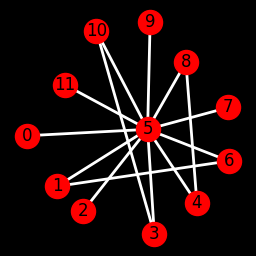

'------grids menos similares--------'

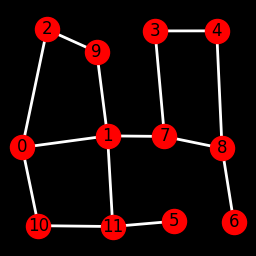

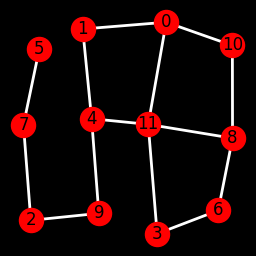

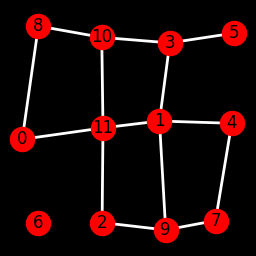

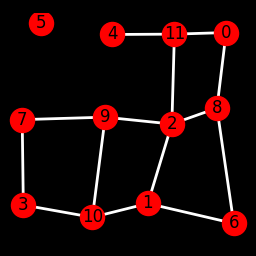

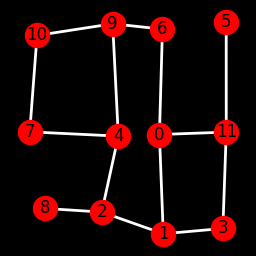

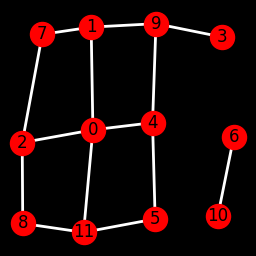

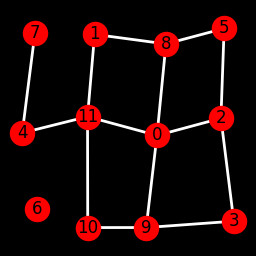

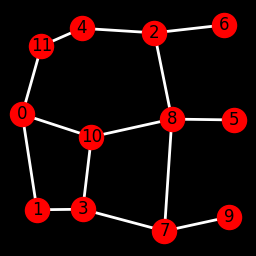

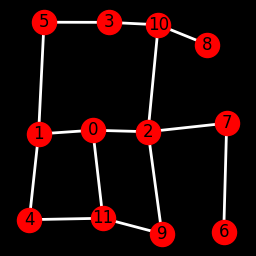

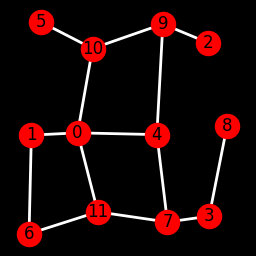

'------grids mais similares--------'

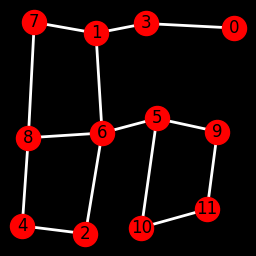

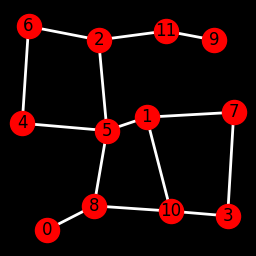

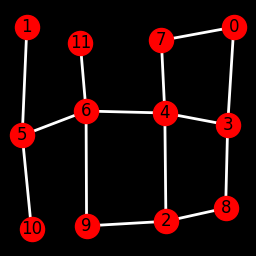

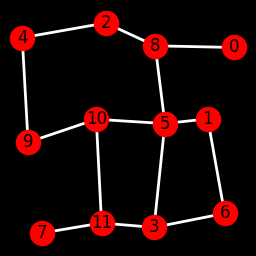

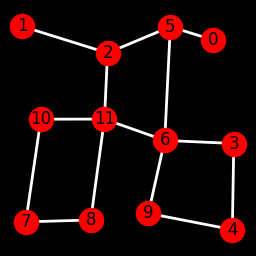

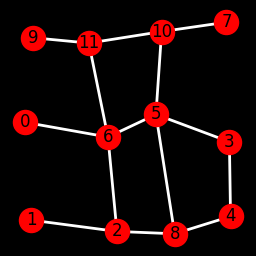

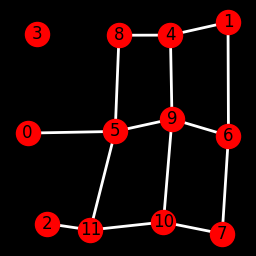

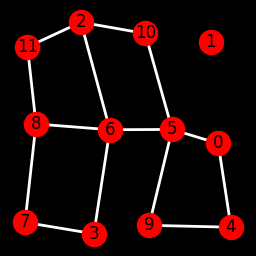

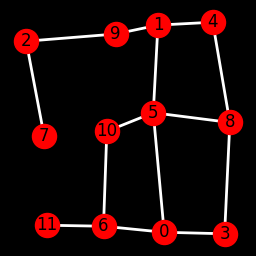

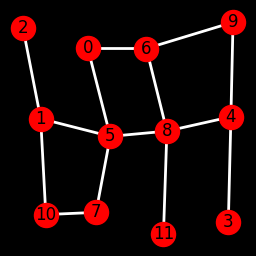

In [23]:
def organize(idx_ref, sims, ds, columns):

    sims_img = sims[idx_ref, columns]
    idx_ord = torch.argsort(sims_img)
    #sims_img_ord = sims_img[idx_ord]
    ds_ord = [ds[columns.start+idx][0] for idx in idx_ord]

    return ds_ord

ds_star_ord = organize(idx_ref, sims_train, ds, slice(0, 1000))
ds_grid_ord = organize(idx_ref, sims_train, ds, slice(1000, 2000))

display("------estrelas menos similares--------", *ds_star_ord[:10])
display("------estrelas mais similares--------", *ds_star_ord[-10:])
display( "------grids menos similares--------", *ds_grid_ord[:10])
display("------grids mais similares--------", *ds_grid_ord[-10:])